# Problem B: Effective thermal conductivity of 2-phase materials
Predicting the effective thermal conductivity $k_{\text{eff}}$ of a two-phase composite material is a classical and practical problem in materials science. The goal is to estimate the bulk conductivity of a heterogeneous material made of two constituents with thermal conductivities $k_1$ and $k_2$. One efficient way to compute the effective thermal conductivity of given 2-phase materials is through numerical homogenization.

In numerical homogenization, we need to solve the steady-state heat equation on a representative volume element (RVE):
$$
-\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{2}
$$
With the following boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$

where $T(x,y)$ indicates the temperature  and $k(x,y)$ indicates thermal conductivity, which is defined piecewise:
$$
k(x,y)=
\begin{cases}
k_1=2.,\quad (x,y)\in\Omega_1\\
k_2=10.,\quad (x,y)\in\Omega_2
\end{cases}
$$
where $\Omega_1$, $\Omega_2$ denote the first phase region and the second phase region, respectively.

<!-- To compute the effective thermal conductivity in the $x$-direction, one can follow the steps:
- **Step 1:** Solve the following PDE:
    $$
    -\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{3}
    $$
  With boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$
- **Step 2:** Compute the **average heat flux:**
    $$
    <q> = \frac{1}{|\Omega|}\int_{\Omega}q~d\Omega
    $$
  where $q(x,y)=-k(x,y)\partial_x T$, and the **average temperature gradient:**
    $$
    <\partial_x T> =  \frac{1}{|\Omega|}\int_{\Omega}\partial_x T~d\Omega
    $$
- **Step 3:** Compute the **effective thermal conductivity (in $x$-direction):**
    $$
    k_{eff} = -\frac{<q>}{<\partial_x T>} = \frac{<k(x,y)\partial_x T>}{<\partial_x T>}
    $$ -->

## Task: predicting the temperature field $T(x,y)$ given 2-phase material $k(x,y)$
In this task, we have collected many materials $k(x,y)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding temperature field $T(x,y)$ through solving the PDE problem $(2)$ with high-precision FEM method. Now, we hope to make a fast prediction of the temperature field $T(x,y)$ (therefore, a fast prediction of the effective conductivity) of a group of materials that are sampled from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{T^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{T^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|T^{(j)}_{pred}(x_i)-T^{(j)}_{true}(x_i)|^2}{\sum_i|T^{(j)}_{true}(x_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the material thermal conductivity, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```EffectiveConductivity.h5```:
- ```k_train```: size(1000, 36, 36), the collected materials (a $36\times 36$ matrix represents each material)
- ```T_train```: size(1000, 36, 36), the collected temperature field (computed on a $36\times 36$ regular mesh)
- ```k_test```: the materials that we are going to predict their corresponding temperature field (Should not be used for training)
- ```T_test```: the ground truth reference of the temperature field (Should not be used for training)
- ```X```: size(36, 36), the $x$-coordiante of locations where the temperature field computed
- ```Y```: size(36, 36), the $y$-coordiante of locations where the temperature field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

In [1]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print(f"Using device to calculate {device} and using data type {dtype}")

Using device to calculate cuda and using data type torch.float32


# 1) Data Processing

<KeysViewHDF5 ['T_test', 'T_train', 'X', 'Y', 'dTx_test', 'dTx_train', 'k_test', 'k_train']>


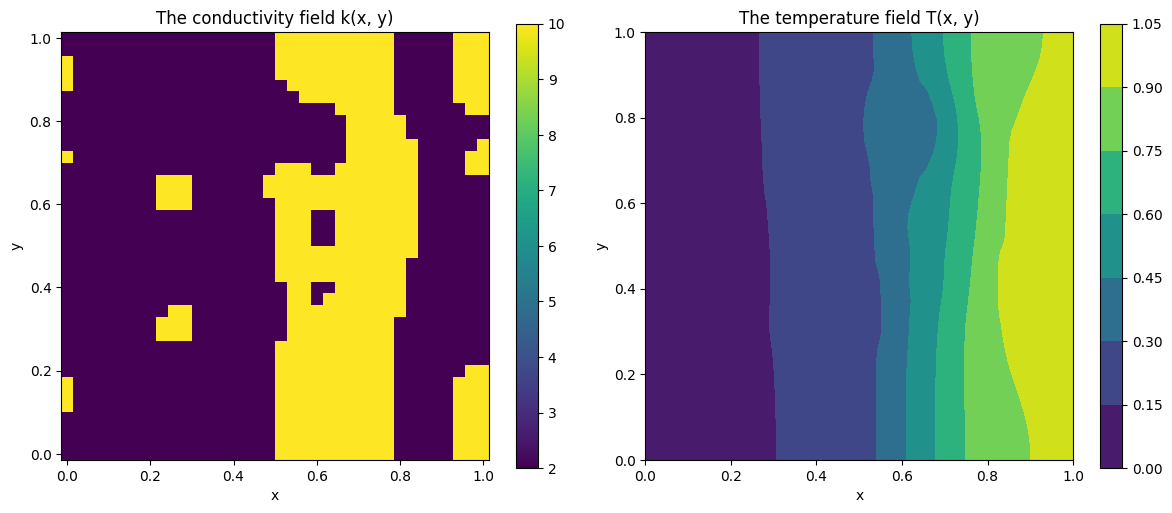

K TRAIN:  torch.Size([1000, 36, 36])
T TRAIN:  torch.Size([1000, 36, 36, 1])
X SHAPE:  torch.Size([36, 36])
Y SHAPE:  torch.Size([36, 36])
K TEST:  torch.Size([200, 36, 36])
T TEST:  torch.Size([200, 36, 36])
X EXT:  torch.Size([1000, 36, 36, 1])
Y EXT:  torch.Size([1000, 36, 36, 1])
KXY SHAPE:  torch.Size([1000, 36, 36, 3])


In [2]:
with h5py.File("EffectiveConductivity.h5", "r") as data:
    print(data.keys())

    k_train = torch.tensor(np.array(data["k_train"]), dtype=dtype)
    T_train = torch.tensor(np.array(data["T_train"]), dtype=dtype)
    k_test = torch.tensor(np.array(data["k_test"]), dtype=dtype)
    T_test =torch.tensor( np.array(data["T_test"]), dtype=dtype)
    x_mesh = torch.tensor(np.array(data["X"]), dtype=dtype)
    y_mesh = torch.tensor(np.array(data["Y"]), dtype=dtype)

    # Boundary Conditions
    k_train[k_train==0]=2.
    k_train[k_train==1]=10.
    k_test[k_test==0]=2.
    k_test[k_test==1]=10.




# Creating plots
inx = 0
fig, axes = plt.subplots(1,2, figsize=(12,5))
#
cntr = axes[0].pcolormesh(x_mesh.cpu(), y_mesh.cpu(), k_train[inx].cpu())
axes[0].set_title('The conductivity field k(x, y)')
axes[0].set_aspect('equal')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(cntr)
#
cntr = axes[1].contourf(x_mesh.cpu(), y_mesh.cpu(), T_train[inx].cpu())
axes[1].set_title('The temperature field T(x, y)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_aspect('equal')
plt.colorbar(cntr)

plt.tight_layout()
plt.show()


### DATA PROCESSING ####

# add a new dimension at the end
k_ext = k_train.unsqueeze(-1)
T_train = T_train.unsqueeze(-1)

x_ext = x_mesh.unsqueeze(0).unsqueeze(-1).repeat(k_train.shape[0], 1, 1, 1)
y_ext = y_mesh.unsqueeze(0).unsqueeze(-1).repeat(k_train.shape[0], 1, 1, 1)
kxy_train = torch.cat([k_ext, x_ext, y_ext], dim=-1)

# print shape
printing = True
if printing:
    print("K TRAIN: ", k_train.shape)
    print("T TRAIN: ", T_train.shape)
    print("X SHAPE: ", x_mesh.shape)
    print("Y SHAPE: ", y_mesh.shape)
    print("K TEST: ", k_test.shape)
    print("T TEST: ", T_test.shape)
    print("X EXT: ", x_ext.shape)
    print("Y EXT: ", y_ext.shape)
    print("KXY SHAPE: ", kxy_train.shape)


# for testing
# Create a DataLoader for the test data
x_ext_test = x_mesh.unsqueeze(0).unsqueeze(-1).repeat(k_test.shape[0],1,1,1)     # [200,128,100,1]
y_ext_test = y_mesh.unsqueeze(0).unsqueeze(-1).repeat(k_test.shape[0],1,1,1) # [200,128,100,1]
k_ext_test = k_test.unsqueeze(-1)

# torch.cat is use to aggregate the values of (k, x, y)
kxy_test = torch.cat([k_ext_test, x_ext_test, y_ext_test], dim=-1)

# 2) Fourier Neural Operator


$\nabla \cdot (a(x, y) \nabla u(x, y)) = 0$



$\mathcal{G}: a(x)\in\mathcal{A}\rightarrow u(x)\in\mathcal{U}$


In [3]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_size, out_size, modes1, modes2, dtype):
        super(SpectralConv2d, self).__init__()

        self.in_size = in_size
        self.out_size = out_size
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = 1./(in_size * out_size)

        if (dtype is None) or (dtype==torch.float32):
            ctype = torch.complex64
        elif dtype==torch.float64:
            ctype = torch.complex128
        else:
            raise ValueError("Unsupported dtype. Use torch.float32 or torch.float64.")

        self.weight1 = nn.Parameter(self.scale * torch.rand(in_size, out_size,
                                                            modes1, modes2, dtype=ctype))
        self.weight2 = nn.Parameter(self.scale * torch.rand(in_size, out_size,
                                                            modes1, modes2, dtype=ctype))

    def compl_mul_2d(self, input, weights):
        """Complex multiplication for spectral convolutional"""
        return torch.einsum('bixy,ioxy->boxy', input, weights)

    def forward(self, x):
        batch_size = x.shape[0]

        # x_ft: size(batch_size, in_size, mx_size, my_size//2+1)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batch_size, self.out_size, x.size(-2), x.size(-1)//2+1,
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weight1)
        out_ft[:, :, -self.modes1:, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weight2)

        # Return to physical space
        # x: size(batch_size, out_size, mx_size, my_size)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))

        return x

class FNO2d(nn.Module):
    def __init__(self, in_size, out_size, modes1, modes2, hidden_list, dtype=None):
        super(FNO2d, self).__init__()
        self.hidden_list = hidden_list

        # Activation function
        self.activation = nn.ReLU()

        # Input layer
        self.fc_in = nn.Linear(in_size, hidden_list[0], dtype=dtype)

        # Hidden layers
        conv_net, w_net = [], []
        hidden_in = hidden_list[0]
        for hidden_out in hidden_list:
            conv_net.append(SpectralConv2d(hidden_in, hidden_out, modes1, modes2, dtype))
            w_net.append(nn.Conv1d(hidden_in, hidden_out, 1, dtype=dtype))
            hidden_in =  hidden_out
        self.spectral_conv = nn.Sequential(*conv_net)
        self.weight_conv = nn.Sequential(*w_net)

        # Output layer
        self.fc_out0 = nn.Linear(hidden_in, 128, dtype=dtype)
        self.fc_out1 = nn.Linear(128, out_size, dtype=dtype)

    def forward(self, ax):
        batch_size = ax.shape[0]

        mx_size, my_size = ax.shape[1], ax.shape[2]

        # Input layer
        ax = self.fc_in(ax)
        ax = ax.permute(0, 3, 1, 2)

        # Spectral conv layer
        for conv, weight, hidden_size in zip(self.spectral_conv, self.weight_conv, self.hidden_list):
            ax1 = conv(ax)
            ax2 = weight(ax.view(batch_size, hidden_size, -1)).view(batch_size, hidden_size, mx_size, my_size)
            ax = self.activation(ax1 + ax2)

        # Output layer
        ax = ax.permute(0, 2, 3, 1)
        ax = self.fc_out0(ax)
        ax = self.activation(ax)

        return self.fc_out1(ax)

mode1, mode2 = 6, 6
hidden_list = [40, 40, 40]
model_k = FNO2d(kxy_train.shape[-1], T_train.shape[-1], mode1, mode2, hidden_list).to(device)

total_params = sum(p.numel() for p in model_k.parameters())
print(f'{total_params:,} total parameters.')


356,057 total parameters.


# 3) Loss Data and Error Functions

In [4]:
class LossClass(object):
    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model

    def loss_data(self, ax_batch, u_batch):
        batch_size = ax_batch.shape[0]

        ax, u = ax_batch.to(self.device), u_batch.to(self.device)

        u_pred = self.u_model(ax)

        loss = torch.norm(u.reshape(batch_size, -1) - u_pred.reshape(batch_size, -1), 2, 1)

        return torch.mean(loss)


    def get_error(self, T_pred, T_test):
        # calculating L2 error for each epoch
        T_testing = T_test.unsqueeze(-1)

        loss = torch.sqrt(torch.sum((T_pred-T_testing)**2)/torch.sum(T_testing**2))

        return loss

#4)  Dataset and Dataloader

In [5]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, ax, u):
        self.ax = ax
        self.u = u

    def __len__(self):
        return self.ax.shape[0]

    def __getitem__(self, idx):
        ax = self.ax[idx]
        u = self.u[idx]
        return ax, u

train_loader = DataLoader(MyDataset(kxy_train, T_train), batch_size=50, shuffle=True)
for kxy_batch, T_batch in train_loader:
    print('kx_batch shape:', kxy_batch.shape, 'T_batch shape:', T_batch.shape)
    break


test_loader = DataLoader(MyDataset(kxy_test, T_test), batch_size=50, shuffle=True)
for kxy_batch, T_batch in test_loader:
    print('kx_batch Test shape:', kxy_batch.shape, 'T_batch Test shape:', T_batch.shape)
    break

kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch Test shape: torch.Size([50, 36, 36, 3]) T_batch Test shape: torch.Size([50, 36, 36])


# 5) Training Process

In [6]:
from tqdm import trange

epochs = 300
lr = 1e-4
optimizer = torch.optim.Adam(params=model_k.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
loss_class = LossClass(model_k)

loss_history = []
error_history = []
for epoch in trange(epochs):
    loss = 0.

    # TRAINING PROCESS
    for kx_batch, T_batch in train_loader:
        loss_train = loss_class.loss_data(kx_batch, T_batch)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss += loss_train

    # Adjust learning rate
    scheduler.step()

    loss = loss / len(train_loader)
    loss_history.append(loss.item())


    # VALIDATION PROCESS
    with torch.no_grad():
        error = 0
        for kx_test, T_batch_test in test_loader:

          T_pred = model_k(kx_test.to(device))
          error += loss_class.get_error(T_pred, T_batch_test.to(device))

        error = error / len(test_loader)
        error_history.append(error.item())

    if (epoch+1) % 100 == 0:
        print(f' Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

 33%|███▎      | 100/300 [00:39<01:15,  2.64it/s]

 Epoch 100/300, Loss: 0.3542, Learning Rate: 0.000050


 67%|██████▋   | 200/300 [01:17<00:38,  2.62it/s]

 Epoch 200/300, Loss: 0.2965, Learning Rate: 0.000025


100%|██████████| 300/300 [01:56<00:00,  2.58it/s]

 Epoch 300/300, Loss: 0.2746, Learning Rate: 0.000006


# 6) Plotting Loss and $L^2$ Error Curves

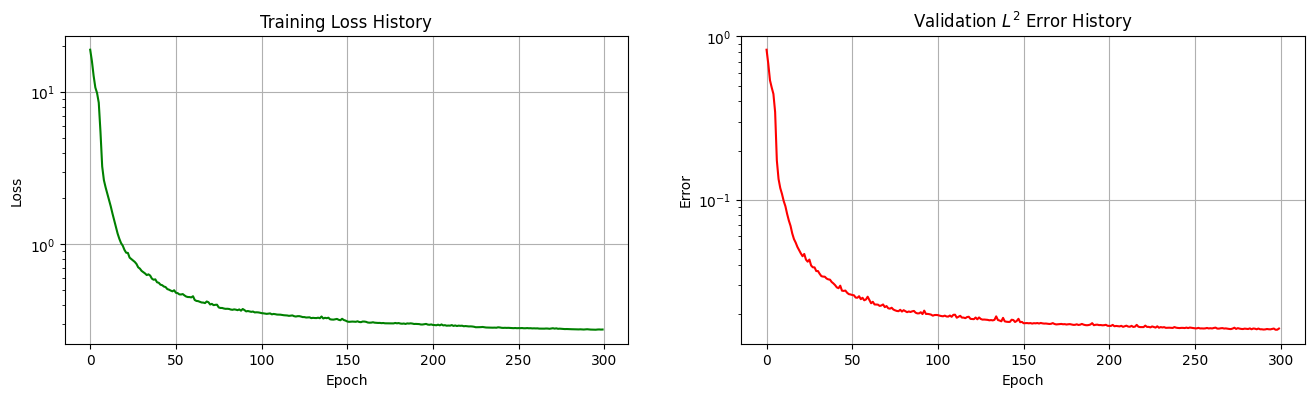

In [7]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
#

axes[0].semilogy(loss_history, color = 'green')
axes[0].set_title('Training Loss History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

#
axes[1].semilogy(error_history, color = 'red')
axes[1].set_title('Validation $L^2$ Error History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Error')
axes[1].grid(True)
#
plt.show()

# 7) Plotting $N$ Amount of Examples of Results

U_pred plot shape:  torch.Size([50, 36, 36])


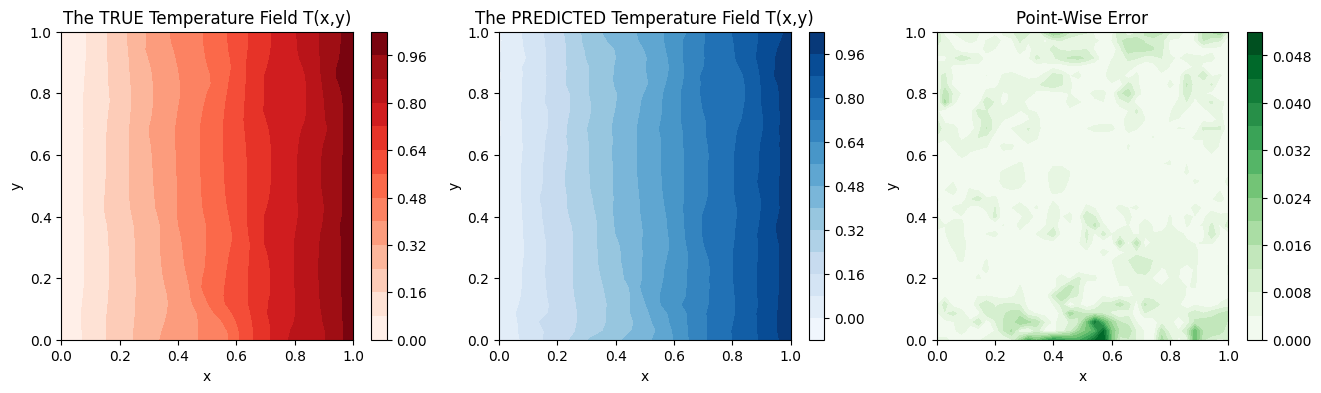

U_pred plot shape:  torch.Size([50, 36, 36])


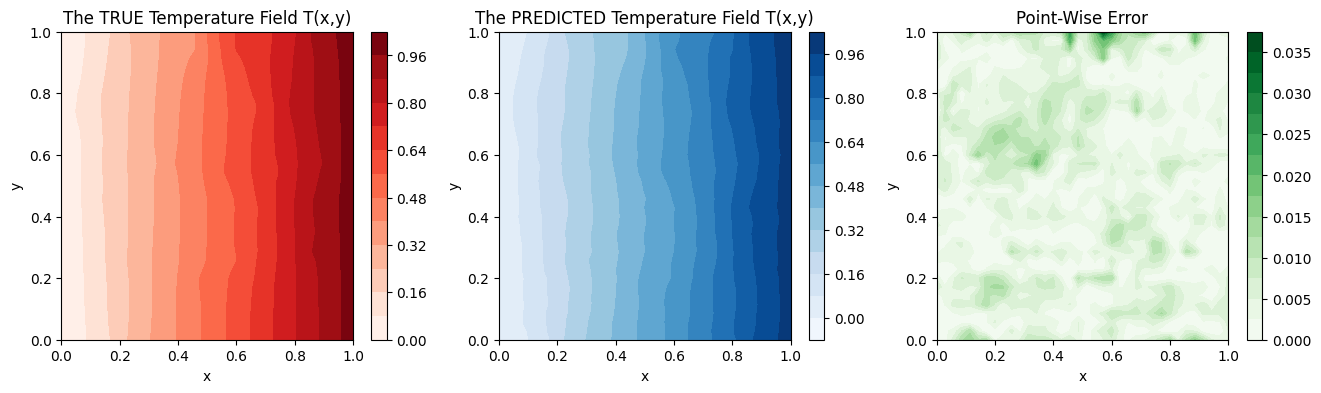

U_pred plot shape:  torch.Size([50, 36, 36])


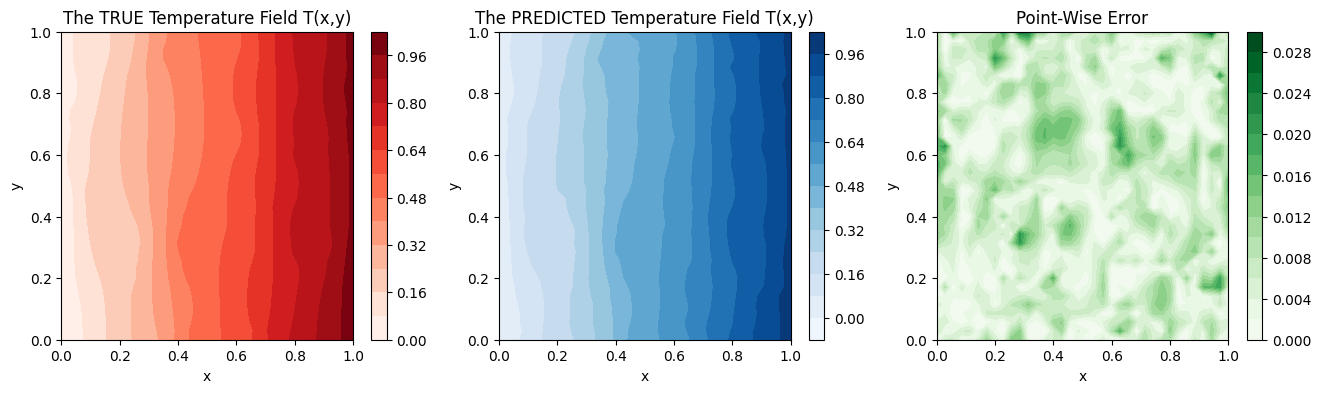

U_pred plot shape:  torch.Size([50, 36, 36])


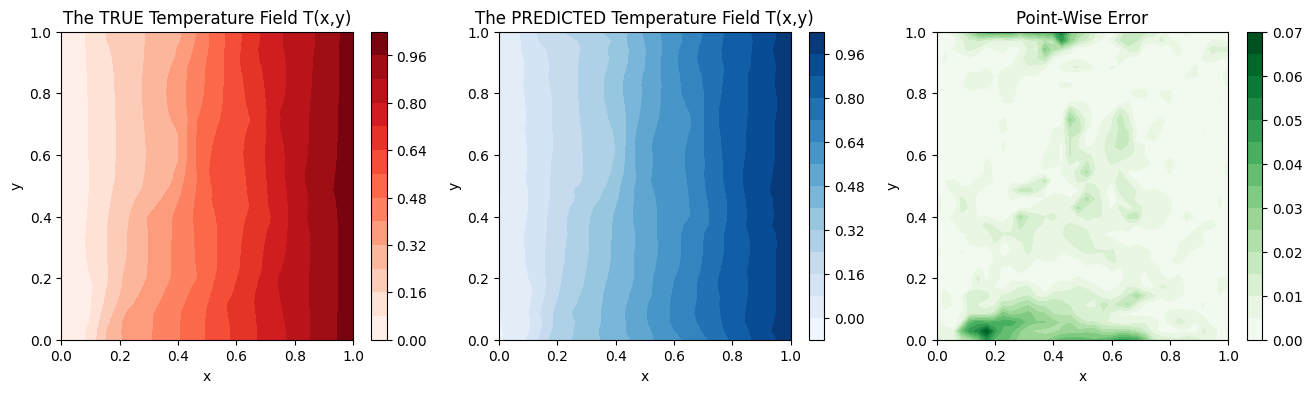

FNO2d(
  (activation): ReLU()
  (fc_in): Linear(in_features=3, out_features=40, bias=True)
  (spectral_conv): Sequential(
    (0): SpectralConv2d()
    (1): SpectralConv2d()
    (2): SpectralConv2d()
  )
  (weight_conv): Sequential(
    (0): Conv1d(40, 40, kernel_size=(1,), stride=(1,))
    (1): Conv1d(40, 40, kernel_size=(1,), stride=(1,))
    (2): Conv1d(40, 40, kernel_size=(1,), stride=(1,))
  )
  (fc_out0): Linear(in_features=40, out_features=128, bias=True)
  (fc_out1): Linear(in_features=128, out_features=1, bias=True)
)

In [8]:
# Plot guessed fields for a few test samples
num_samples_to_plot = 5 # You can adjust this number

model_k.eval()  # Set the model to evaluation mode

with torch.no_grad():

    for i, (kxy_batch, T_batch) in enumerate(test_loader):
        if i >= num_samples_to_plot:
            break

        kxy, T_true = kxy_batch.to(device), T_batch.to(device)

        T_pred = model_k(kxy)
        T_pred_plot = T_pred.squeeze()
        print("U_pred plot shape: ", T_pred_plot.shape) # [50, 36, 36]


        inx = i
        fig, axes = plt.subplots(1,3, figsize=(16,4))
        #

        cntr = axes[0].contourf(x_mesh.cpu(), y_mesh.cpu(), T_true[inx].cpu(), levels = 15, cmap = 'Reds')
        axes[0].set_title('The TRUE Temperature Field T(x,y)')
        axes[0].set_xlabel('x')
        axes[0].set_ylabel('y')
        plt.colorbar(cntr)
        #
        cntr = axes[1].contourf(x_mesh.cpu(), y_mesh.cpu(), T_pred_plot[inx].cpu(), levels = 15, cmap = 'Blues')
        axes[1].set_title('The PREDICTED Temperature Field T(x,y)')
        axes[1].set_xlabel('x')
        axes[1].set_ylabel('y')
        plt.colorbar(cntr)
        #
        cntr = axes[2].contourf(x_mesh.cpu(), y_mesh.cpu(), torch.abs(T_true[inx].cpu() - T_pred_plot[inx].cpu()), levels = 15, cmap = 'Greens')
        axes[2].set_title('Point-Wise Error')
        axes[2].set_xlabel('x')
        axes[2].set_ylabel('y')
        plt.colorbar(cntr)

        plt.show()


model_k.train() # Set the model back to training mode

# 8) Plotting the first instance of the Testing Dataset

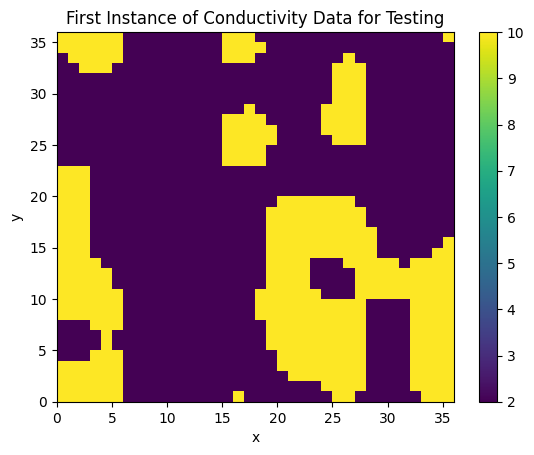

In [9]:
cntr = plt.pcolormesh(k_test[0])
plt.title('First Instance of Conductivity Data for Testing')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(cntr)
plt.show()

torch.Size([200, 36, 36, 3])
torch.Size([1, 36, 36, 3])
T First:  torch.Size([36, 36])
T PRED:  torch.Size([36, 36])


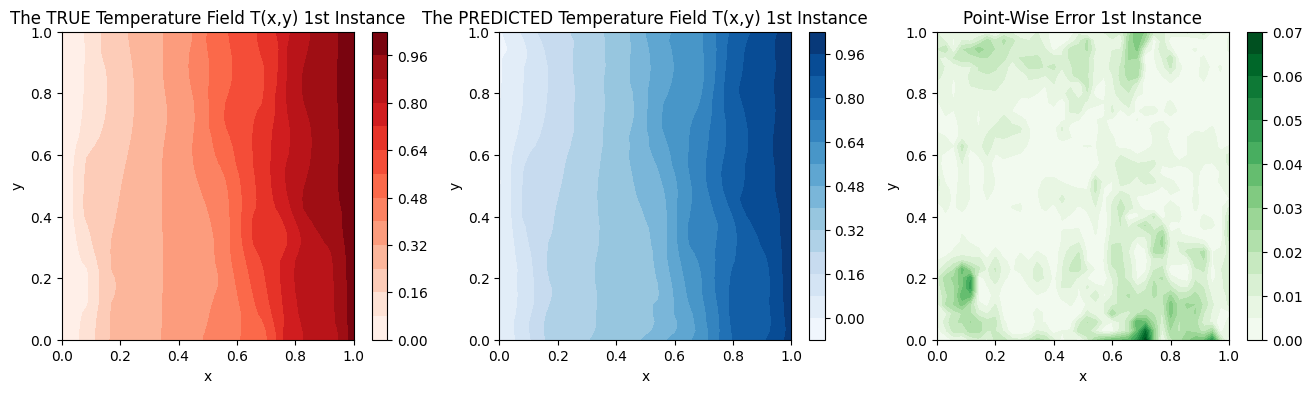

FNO2d(
  (activation): ReLU()
  (fc_in): Linear(in_features=3, out_features=40, bias=True)
  (spectral_conv): Sequential(
    (0): SpectralConv2d()
    (1): SpectralConv2d()
    (2): SpectralConv2d()
  )
  (weight_conv): Sequential(
    (0): Conv1d(40, 40, kernel_size=(1,), stride=(1,))
    (1): Conv1d(40, 40, kernel_size=(1,), stride=(1,))
    (2): Conv1d(40, 40, kernel_size=(1,), stride=(1,))
  )
  (fc_out0): Linear(in_features=40, out_features=128, bias=True)
  (fc_out1): Linear(in_features=128, out_features=1, bias=True)
)

In [10]:
model_k.eval()  # Set the model to evaluation mode

#first instances
kxy_first = kxy_test[0].to(device)
kxy_first = kxy_first.unsqueeze(0)
T_first = T_test[0].to(device)

with torch.no_grad():

    print(kxy_test.shape)
    print(kxy_first.shape)
    T_pred_first = model_k(kxy_first)
    print("T First: ", T_first.shape)
    T_pred_first = T_pred_first.squeeze(0).squeeze(-1)
    print("T PRED: ", T_pred_first.shape)

    fig, axes = plt.subplots(1,3, figsize=(16,4))
    #

    cntr = axes[0].contourf(x_mesh.cpu(), y_mesh.cpu(), T_first.cpu(), levels = 15, cmap = 'Reds')
    axes[0].set_title('The TRUE Temperature Field T(x,y) 1st Instance')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    plt.colorbar(cntr)
    #
    cntr = axes[1].contourf(x_mesh.cpu(), y_mesh.cpu(), T_pred_first.cpu(), levels = 15, cmap = 'Blues')
    axes[1].set_title('The PREDICTED Temperature Field T(x,y) 1st Instance')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    plt.colorbar(cntr)
    #
    cntr = axes[2].contourf(x_mesh.cpu(), y_mesh.cpu(), torch.abs(T_first.cpu() - T_pred_first.cpu()), levels = 15, cmap = 'Greens')
    axes[2].set_title('Point-Wise Error 1st Instance')
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y')
    plt.colorbar(cntr)

    plt.show()


model_k.train() # Set the model back to training mode